## First Iteration: Planwise Recommendation System

In [9]:
import recommenders
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eda_pipeline


## Paths

In [10]:
path_destinations = "archive/Expanded_Destinations.csv"
path_reviews = "archive/Final_Updated_Expanded_Reviews.csv"
path_user_history = "archive/Final_Updated_Expanded_UserHistory.csv"
path_users = "archive/Final_Updated_Expanded_Users.csv"

## Load the data into the EDAPipeline

In [11]:
eda_destinations = eda_pipeline.EDAPipeline(path_destinations)
eda_reviews = eda_pipeline.EDAPipeline(path_reviews)
eda_user_history = eda_pipeline.EDAPipeline(path_user_history)
eda_users = eda_pipeline.EDAPipeline(path_users)


### EDA: DESTINATIONS

In [12]:
eda_destinations.load_data()


Dataset Shape: (1000, 6)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DestinationID    1000 non-null   int64  
 1   Name             1000 non-null   object 
 2   State            1000 non-null   object 
 3   Type             1000 non-null   object 
 4   Popularity       1000 non-null   float64
 5   BestTimeToVisit  1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


First few rows:

   DestinationID               Name              State        Type  Popularity BestTimeToVisit
0              1          Taj Mahal      Uttar Pradesh  Historical    8.691906         Nov-Feb
1              2        Goa Beaches                Goa       Beach    8.605032         Nov-Mar
2              3        Jaipur City          Rajasthan        City    9.225372         Oct-Mar
3              4  Kerala

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun
...,...,...,...,...,...,...
995,996,Taj Mahal,Uttar Pradesh,Historical,8.133818,Nov-Feb
996,997,Goa Beaches,Goa,Beach,8.203519,Nov-Mar
997,998,Jaipur City,Rajasthan,City,8.308435,Oct-Mar
998,999,Kerala Backwaters,Kerala,Nature,8.961741,Sep-Mar


In [13]:
eda_destinations.check_data_quality()


Statistical Summary:

       DestinationID  Popularity
count        1000.00     1000.00
mean          500.50        8.51
std           288.82        0.57
min             1.00        7.50
25%           250.75        8.03
50%           500.50        8.50
75%           750.25        9.02
max          1000.00        9.50


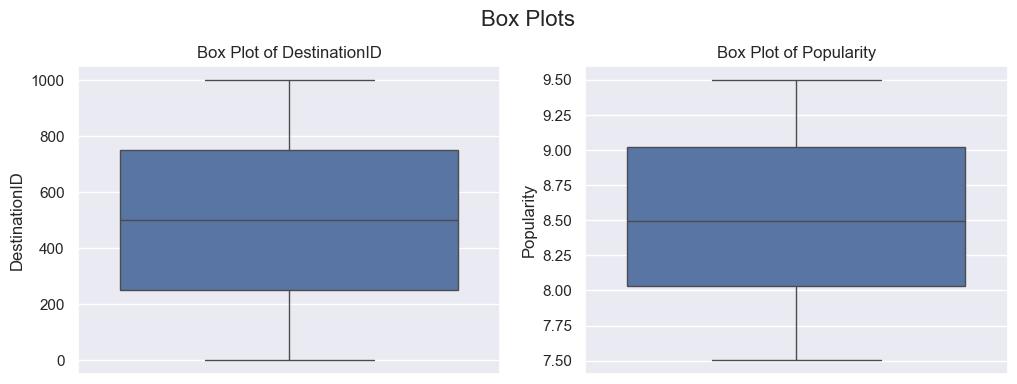

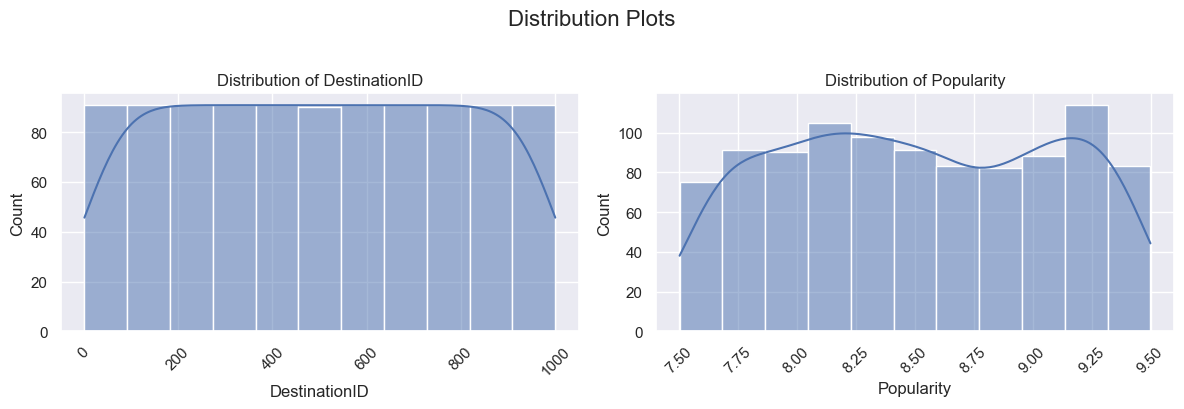

<Figure size 640x480 with 0 Axes>


Summary statistics:

       DestinationID  Popularity
count        1000.00     1000.00
mean          500.50        8.51
std           288.82        0.57
min             1.00        7.50
25%           250.75        8.03
50%           500.50        8.50
75%           750.25        9.02
max          1000.00        9.50


In [14]:
eda_destinations.analyze_numerical()

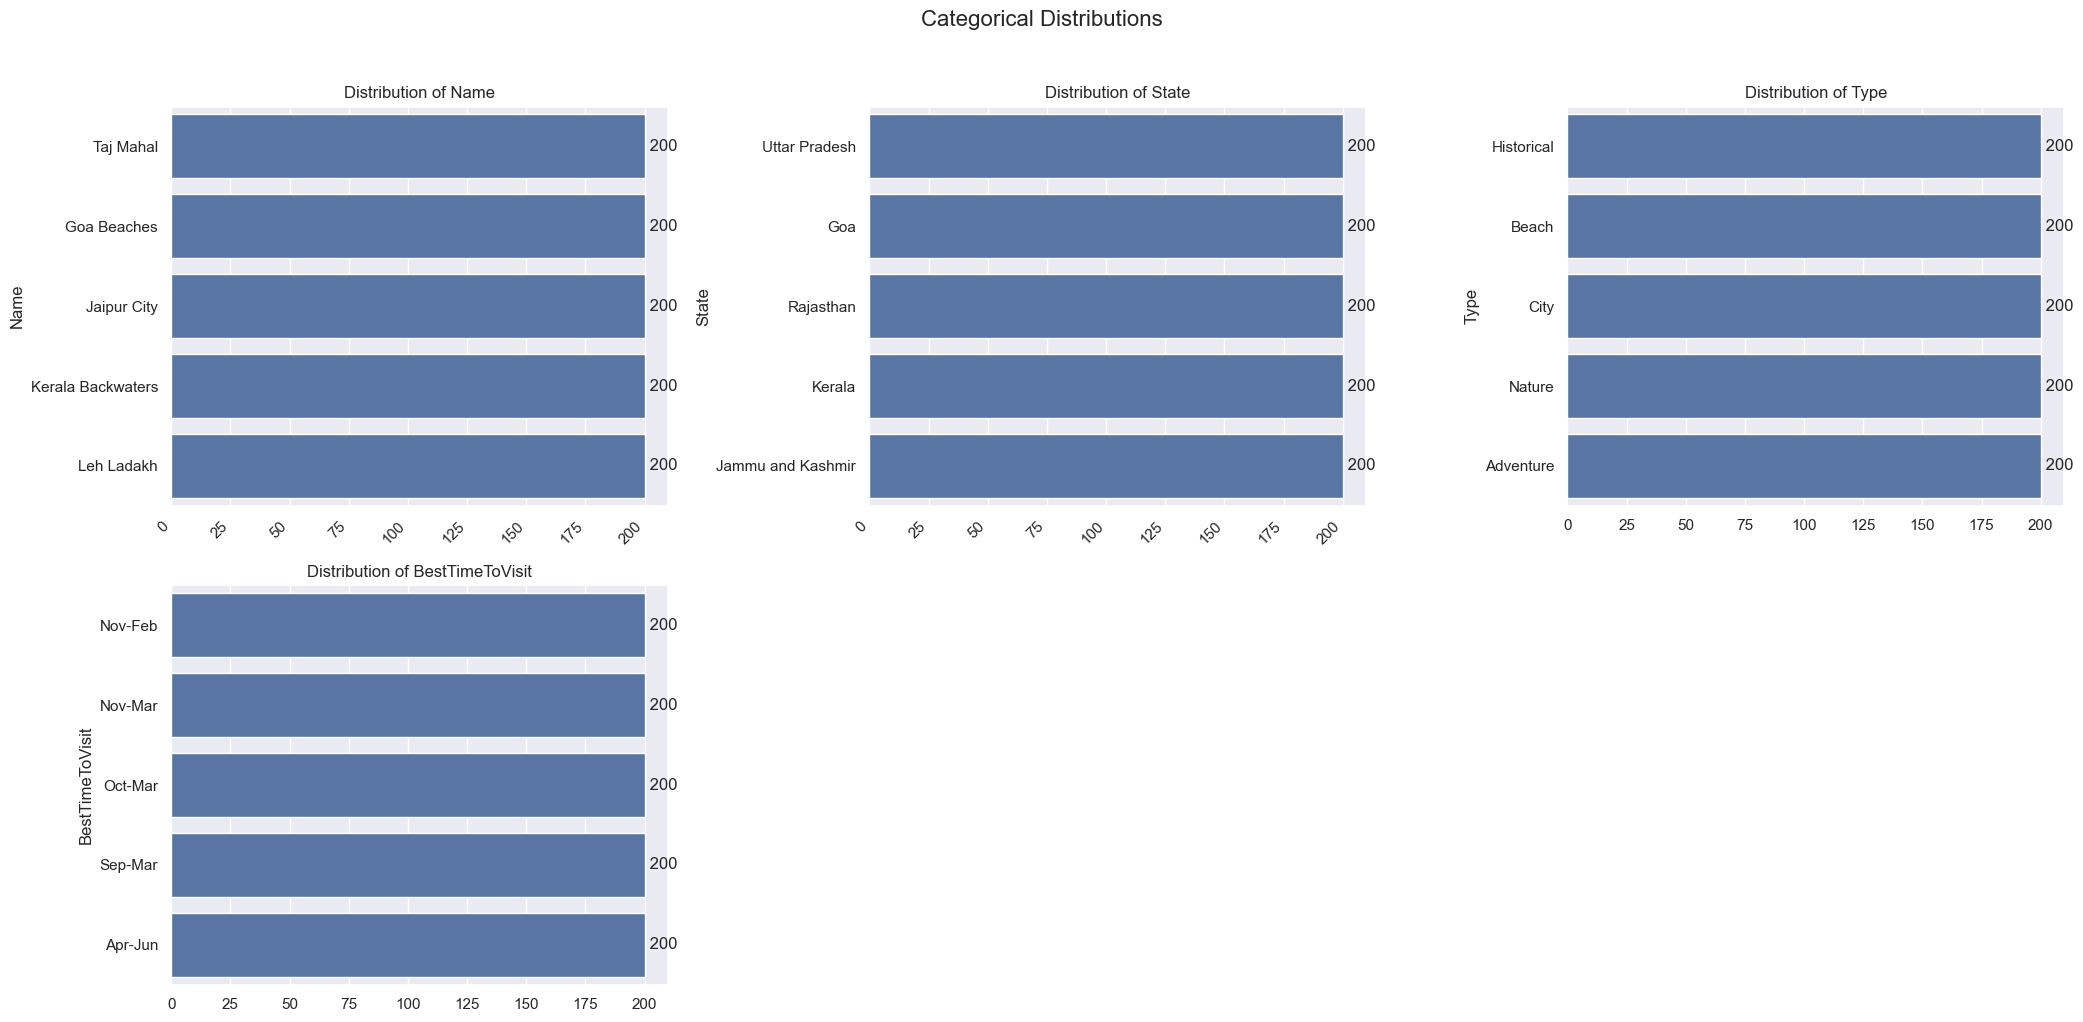


Frequency distributions (proportions):

Name:
Name
Taj Mahal            0.2
Goa Beaches          0.2
Jaipur City          0.2
Kerala Backwaters    0.2
Leh Ladakh           0.2
Number of unique values: 5
Most common value: Goa Beaches (20.00%)

State:
State
Uttar Pradesh        0.2
Goa                  0.2
Rajasthan            0.2
Kerala               0.2
Jammu and Kashmir    0.2
Number of unique values: 5
Most common value: Goa (20.00%)

Type:
Type
Historical    0.2
Beach         0.2
City          0.2
Nature        0.2
Adventure     0.2
Number of unique values: 5
Most common value: Adventure (20.00%)

BestTimeToVisit:
BestTimeToVisit
Nov-Feb    0.2
Nov-Mar    0.2
Oct-Mar    0.2
Sep-Mar    0.2
Apr-Jun    0.2
Number of unique values: 5
Most common value: Apr-Jun (20.00%)


In [15]:
eda_destinations.analyze_categorical()

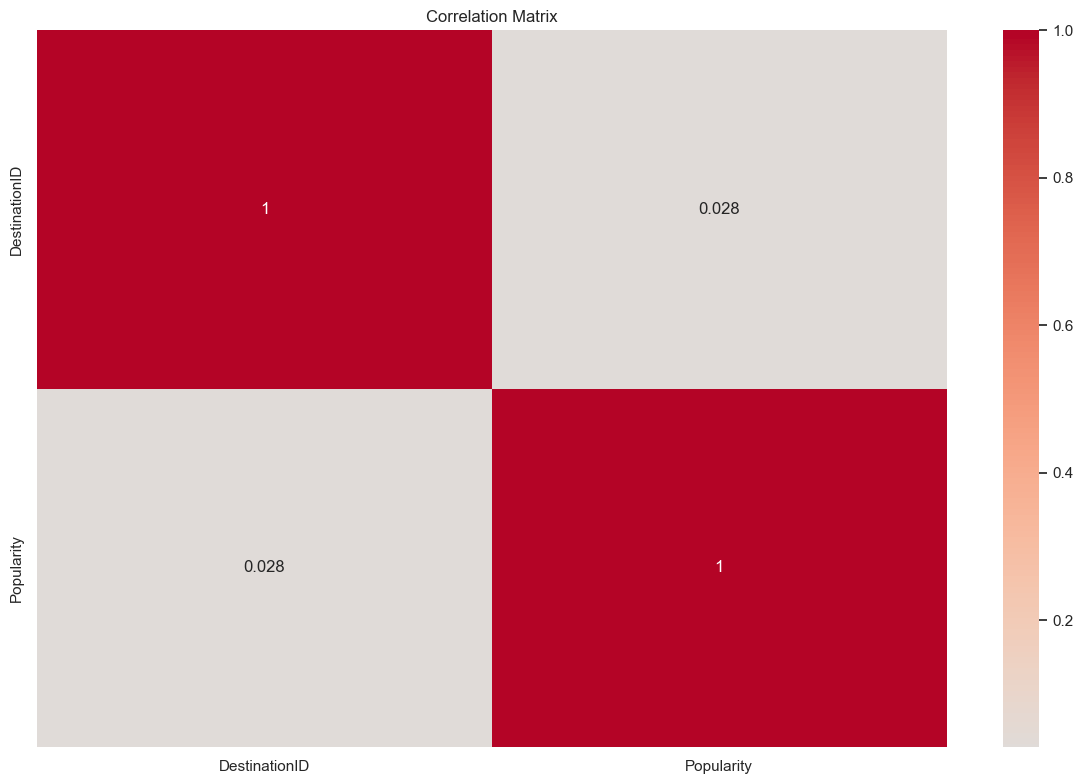


Strong correlations (|correlation| > 0.5):

No strong correlations found


In [16]:
eda_destinations.correlation_analysis()

### EDA: REVIEWS

In [17]:
eda_reviews.load_data()


Dataset Shape: (999, 5)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ReviewID       999 non-null    int64 
 1   DestinationID  999 non-null    int64 
 2   UserID         999 non-null    int64 
 3   Rating         999 non-null    int64 
 4   ReviewText     999 non-null    object
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


First few rows:

   ReviewID  DestinationID  UserID  Rating            ReviewText
0         1            178     327       2  Incredible monument!
1         2            411     783       1    Loved the beaches!
2         3            927      12       2   A historical wonder
3         4            358     959       3  Incredible monument!
4         5            989     353       2    Loved the beaches!


,ReviewID,DestinationID,UserID,Rating,ReviewText
0,1,178,327,2,Incredible monument!
1,2,411,783,1,Loved the beaches!
2,3,927,12,2,A historical wonder
3,4,358,959,3,Incredible monument!
4,5,989,353,2,Loved the beaches!
...,...,...,...,...,...
994,995,231,346,5,Loved the beaches!
995,996,140,140,3,A historical wonder
996,997,823,858,5,Incredible monument!
997,998,279,839,2,Loved the beaches!


In [18]:
eda_reviews.check_data_quality()


Statistical Summary:

       ReviewID  DestinationID  UserID  Rating
count    999.00         999.00  999.00  999.00
mean     500.00         506.39  498.61    3.02
std      288.53         285.60  286.96    1.42
min        1.00           1.00    2.00    1.00
25%      250.50         273.00  252.00    2.00
50%      500.00         501.00  494.00    3.00
75%      749.50         752.00  747.50    4.00
max      999.00        1000.00  999.00    5.00


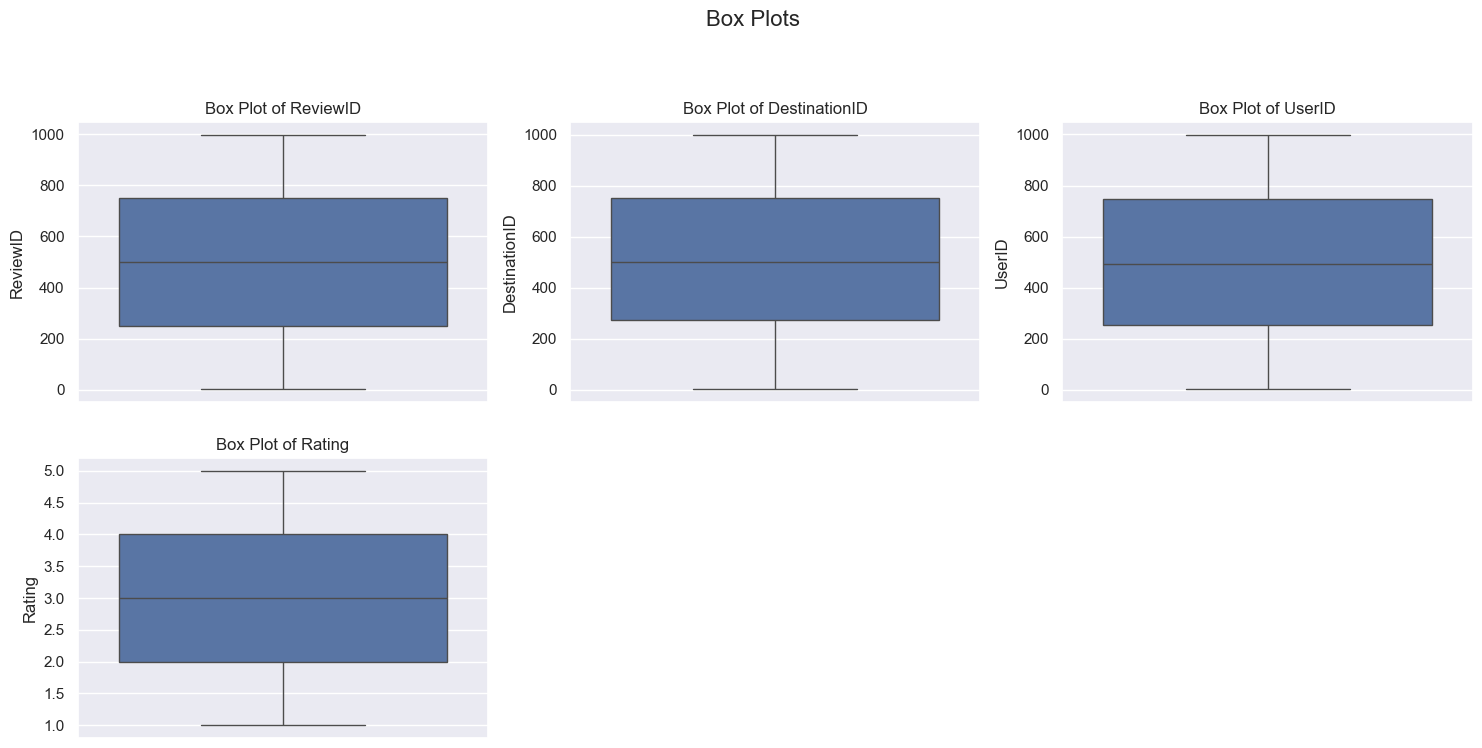

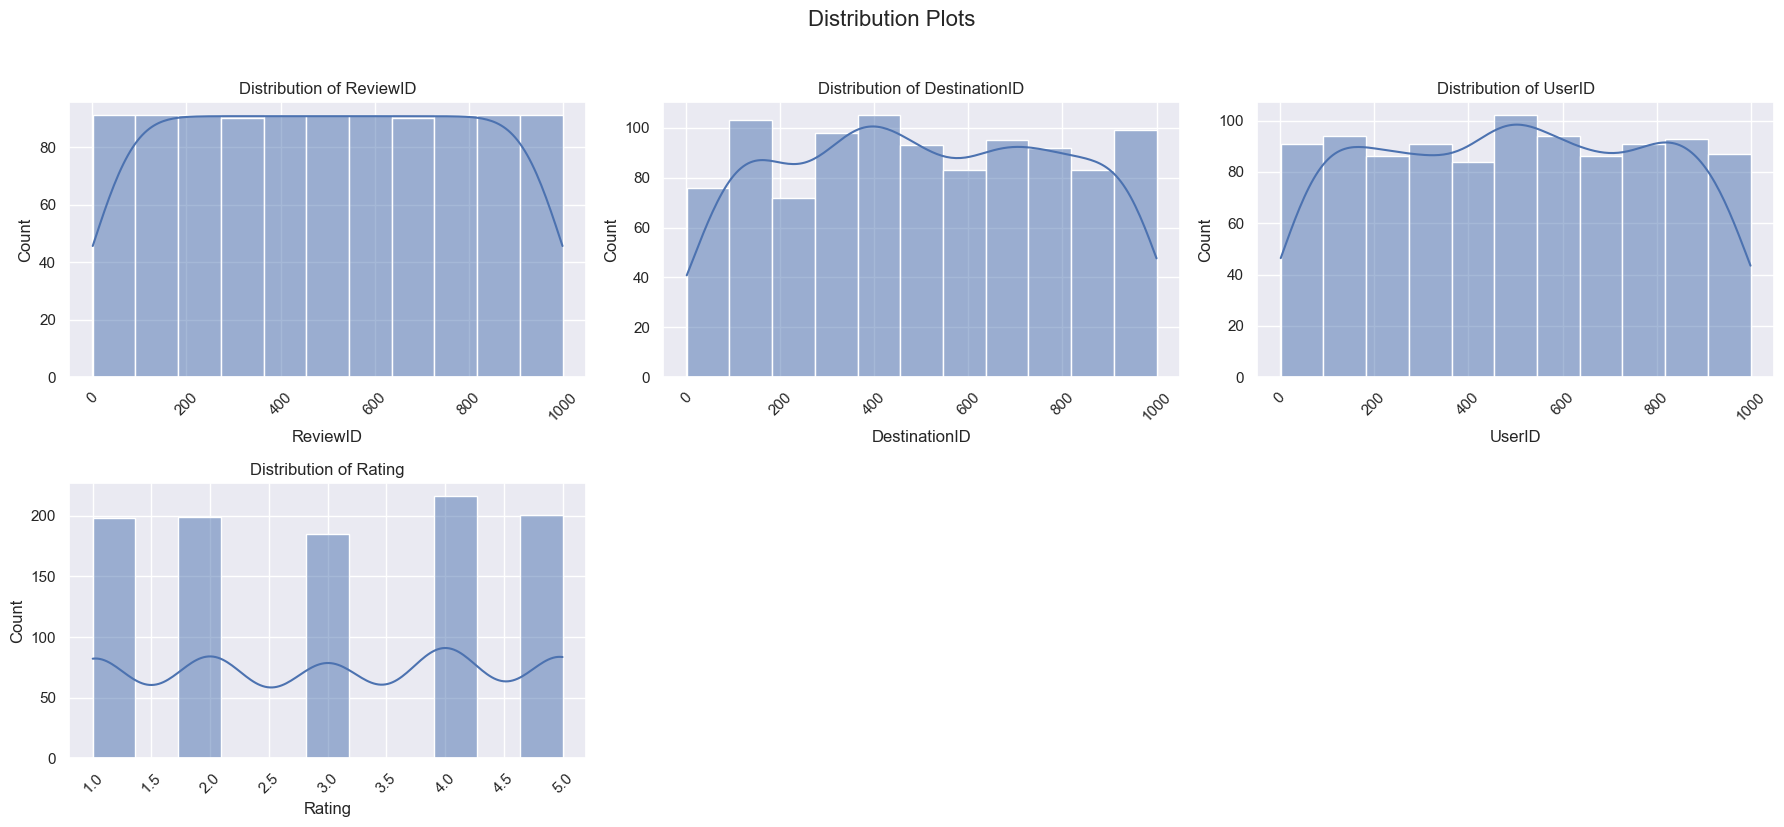

<Figure size 640x480 with 0 Axes>


Summary statistics:

       ReviewID  DestinationID  UserID  Rating
count    999.00         999.00  999.00  999.00
mean     500.00         506.39  498.61    3.02
std      288.53         285.60  286.96    1.42
min        1.00           1.00    2.00    1.00
25%      250.50         273.00  252.00    2.00
50%      500.00         501.00  494.00    3.00
75%      749.50         752.00  747.50    4.00
max      999.00        1000.00  999.00    5.00


In [19]:
eda_reviews.analyze_numerical()

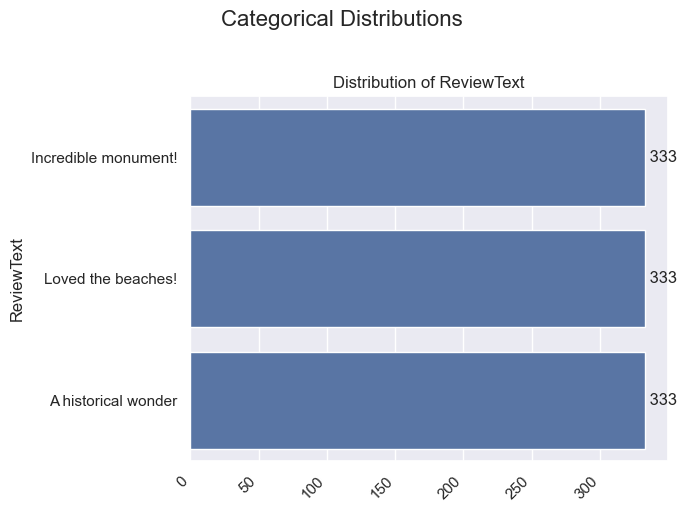


Frequency distributions (proportions):

ReviewText:
ReviewText
Incredible monument!    0.333333
Loved the beaches!      0.333333
A historical wonder     0.333333
Number of unique values: 3
Most common value: A historical wonder (33.33%)


In [20]:
eda_reviews.analyze_categorical()

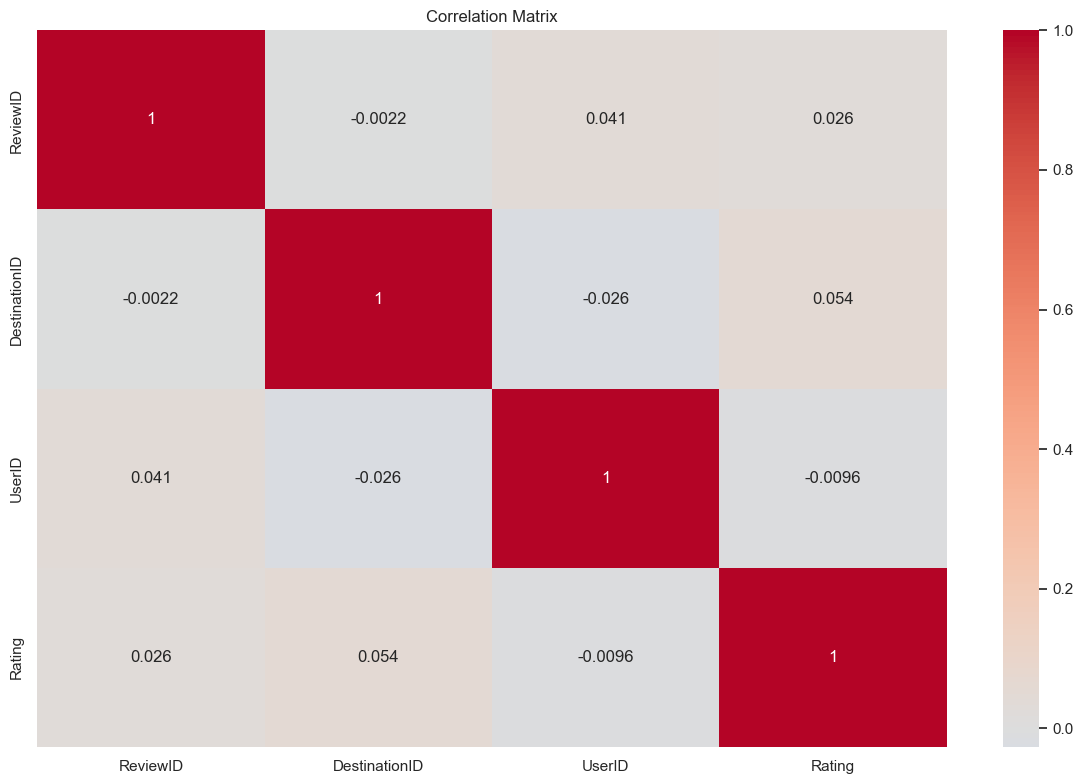


Strong correlations (|correlation| > 0.5):

No strong correlations found


In [21]:
eda_reviews.correlation_analysis()

### EDA: USER HISTORY

In [22]:
eda_user_history.load_data()

Error loading data: [Errno 2] No such file or directory: 'reco/examples/archive/Final_Updated_Expanded_UserHistory.csv'


FileNotFoundError: [Errno 2] No such file or directory: 'reco/examples/archive/Final_Updated_Expanded_UserHistory.csv'

In [ ]:
eda_user_history.check_data_quality()

In [ ]:
eda_user_history.analyze_numerical()

In [ ]:
eda_user_history.analyze_categorical()

In [ ]:
eda_user_history.correlation_analysis()

### EDA: USERS

In [ ]:
eda_users.load_data()

In [ ]:
eda_users.check_data_quality()

In [ ]:
eda_users.analyze_numerical()

In [ ]:
eda_users.analyze_categorical()

In [ ]:
eda_users.correlation_analysis()